In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [3]:
# Set random seeds for reproducibility
seed_val = 42
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load and inspect data
def load_data(file_path):
    """Load and prepare the dataset."""
    # Load data
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print("\nSample data:")
    print(df.head())

    return df

In [5]:
# Data cleaning and preprocessing
def clean_text(text):
    """Clean and preprocess text data."""
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user @ references and '#' from tweet
        text = re.sub(r'\@\w+|\#', '', text)
        # Remove RT (retweet) tags
        text = re.sub(r'^RT[\s]+', '', text)
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove special characters, numbers and punctuations
        text = re.sub(r'[^\w\s]', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return ""

def preprocess_data(df):
    """Preprocess the dataset."""
    # Make a copy to avoid modifying original data
    df_processed = df.copy()

    # Clean the tweet text
    df_processed['clean_tweet'] = df_processed['tweet'].apply(clean_text)

    # Remove empty tweets
    df_processed = df_processed[df_processed['clean_tweet'].str.strip() != '']

    # Convert class labels to integers if needed
    if df_processed['class'].dtype != 'int64':
        df_processed['class'] = df_processed['class'].astype(int)

    print(f"Dataset shape after preprocessing: {df_processed.shape}")

    return df_processed


In [20]:
import pandas as pd
from sklearn.utils import resample

def stabilize_classes(df, target_col='class', target_n=4163):
    counts = df[target_col].value_counts()
    parts = []

    for cls, cls_df in df.groupby(target_col):
        cnt = len(cls_df)
        if cnt > target_n:
            # only downsample large classes
            part = resample(
                cls_df,
                replace=False,
                n_samples=target_n,
                random_state=42
            )
        else:
            # leave smaller classes untouched
            part = cls_df
        parts.append(part)

    balanced = pd.concat(parts).sample(frac=1, random_state=42).reset_index(drop=True)

    print("Original counts:\n", counts.to_dict())
    print(f"Downsampled any class > {target_n}; kept smaller ones unchanged.")
    print("New counts:\n", balanced[target_col].value_counts().to_dict())

    return balanced


In [6]:
# Exploratory Data Analysis
def perform_eda(df):
    """Perform exploratory data analysis."""
    print("\n--- Exploratory Data Analysis ---")

    # Class distribution
    print("\nClass distribution:")
    class_counts = df['class'].value_counts()
    print(class_counts)

    # Create a pie chart for class distribution
    plt.figure(figsize=(8, 6))
    labels = ['Hate Speech', 'Offensive Language', 'Neither']
    plt.pie(class_counts.sort_index(), labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution')
    plt.axis('equal')
    plt.savefig('class_distribution.png')

    # Text length analysis
    df['text_length'] = df['clean_tweet'].apply(len)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y='text_length', data=df)
    plt.title('Text Length by Class')
    plt.xlabel('Class (0: Hate Speech, 1: Offensive Language, 2: Neither)')
    plt.ylabel('Text Length')
    plt.savefig('text_length_by_class.png')

    # Annotator agreement analysis
    agreement_cols = ['hate_speech', 'offensive_language', 'neither']
    if all(col in df.columns for col in agreement_cols):
        # Calculate agreement percentage per tweet
        total_votes = df[agreement_cols].sum(axis=1)
        df['agreement_percent'] = df.apply(lambda row: max(row[agreement_cols]) / row[agreement_cols].sum() * 100
                                        if row[agreement_cols].sum() > 0 else 0, axis=1)

        plt.figure(figsize=(10, 6))
        sns.histplot(df['agreement_percent'], bins=10)
        plt.title('Annotator Agreement Percentage')
        plt.xlabel('Agreement Percentage')
        plt.ylabel('Count')
        plt.savefig('annotator_agreement.png')

    return df


In [7]:
# Custom dataset class for PyTorch
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [8]:
# Training function
def train_model(model, train_dataloader, val_dataloader, epochs=4):
    # Optimizer
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Lists to keep track of metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        train_loss = 0

        for batch in tqdm(train_dataloader, desc="Training"):
            # Move tensors to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Clear previous gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss

            # Backward pass
            loss.backward()

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Average training loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        predictions = []
        true_labels = []

        for batch in tqdm(val_dataloader, desc="Validation"):
            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.no_grad():
                outputs = model(**batch)

            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)

        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        val_accuracy = accuracy_score(true_labels, predictions)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions))

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_validation_loss.png')

    # Plot validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), val_accuracies, 'g-')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('validation_accuracy.png')

    return model

In [9]:
# Evaluation function
def evaluate_model(model, test_dataloader):
    """Evaluate the model on test data."""
    model.eval()
    predictions = []
    true_labels = []

    for batch in tqdm(test_dataloader, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(labels)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions)

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Hate Speech', 'Offensive', 'Neither'],
                yticklabels=['Hate Speech', 'Offensive', 'Neither'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'predictions': predictions
    }

In [25]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
)
import torch.nn as nn

def main(
    file_path,
    test_size=0.2,
    val_size=0.1,
    batch_size=16,
    epochs=4,
    max_len=128,
    target_n=4163
):
    # 1. Load & preprocess
    df = load_data(file_path)
    df_proc = preprocess_data(df)

    # 2. Balance classes 1 & 2 down to target_n; keep class 0 unchanged
    df_bal = stabilize_classes(df_proc, target_col='class', target_n=target_n)

    # 3. (Optional) EDA
    perform_eda(df_bal)

    # 4. Split
    train_val, test_df = train_test_split(
        df_bal, test_size=test_size, random_state=42,
        stratify=df_bal['class']
    )
    train_df, val_df = train_test_split(
        train_val,
        test_size=val_size / (1 - test_size),
        random_state=42,
        stratify=train_val['class']
    )
    print(f"Train/Val/Test sizes: {len(train_df)}/{len(val_df)}/{len(test_df)}")

    # 5. Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # 6. Tokenizer & model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=3,
        output_attentions=False,
        output_hidden_states=False
    ).to(device)

    # 7. Datasets & loaders
    train_ds = HateSpeechDataset(train_df['clean_tweet'].tolist(), train_df['class'].tolist(),
                                 tokenizer, max_len)
    val_ds   = HateSpeechDataset(val_df['clean_tweet'].tolist(),   val_df['class'].tolist(),
                                 tokenizer, max_len)
    test_ds  = HateSpeechDataset(test_df['clean_tweet'].tolist(),  test_df['class'].tolist(),
                                 tokenizer, max_len)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size)

    # 8. Train & evaluate
    #    Note: train_model(model, train_loader, val_loader, epochs=...)
    trained_model = train_model(model, train_loader, val_loader, epochs=epochs)
    results = evaluate_model(trained_model, test_loader)
    print("Test results:", results)

    # 9. Save
    torch.save(trained_model.state_dict(), 'hate_speech_distilbert_model.pt')
    print("Model saved as hate_speech_distilbert_model.pt")

    return trained_model, results


In [11]:
# Function to predict on new text
def predict_hate_speech(text, model, tokenizer, device):
    """Predict hate speech category for a new text."""
    # Clean text
    cleaned_text = clean_text(text)

    # Tokenize
    encoding = tokenizer(
        cleaned_text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move to device
    encoding = {k: v.to(device) for k, v in encoding.items()}

    # Prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).cpu().item()

    # Map prediction to category
    categories = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
    return categories[prediction]


Dataset shape: (24783, 7)

Sample data:
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
Dataset shape after preprocessing: (24783, 8)
Original counts:
 {1: 19190, 2: 4163, 0: 1430}
Downsampled any class > 4163; kept smaller ones unchanged.
New counts:
 {1: 4163, 2: 4163, 0: 1430

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Training: 100%|██████████| 427/427 [01:12<00:00,  5.86it/s]


Average training loss: 0.4791


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.86it/s]


Validation Loss: 0.3423
Validation Accuracy: 0.8760

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       143
           1       0.90      0.86      0.88       417
           2       0.94      0.96      0.95       416

    accuracy                           0.88       976
   macro avg       0.83      0.83      0.83       976
weighted avg       0.88      0.88      0.88       976


Epoch 2/3
----------


Training: 100%|██████████| 427/427 [01:14<00:00,  5.73it/s]


Average training loss: 0.3131


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.02it/s]


Validation Loss: 0.3406
Validation Accuracy: 0.8914

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       143
           1       0.88      0.91      0.89       417
           2       0.95      0.96      0.95       416

    accuracy                           0.89       976
   macro avg       0.86      0.83      0.84       976
weighted avg       0.89      0.89      0.89       976


Epoch 3/3
----------


Training: 100%|██████████| 427/427 [01:16<00:00,  5.60it/s]


Average training loss: 0.2590


Validation: 100%|██████████| 61/61 [00:03<00:00, 17.15it/s]


Validation Loss: 0.3520
Validation Accuracy: 0.8801

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       143
           1       0.89      0.87      0.88       417
           2       0.94      0.96      0.95       416

    accuracy                           0.88       976
   macro avg       0.83      0.83      0.83       976
weighted avg       0.88      0.88      0.88       976



Testing: 100%|██████████| 122/122 [00:07<00:00, 16.90it/s]



Test Accuracy: 0.8735

Confusion Matrix:
[[173  78  35]
 [ 64 737  32]
 [ 15  23 795]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       286
           1       0.88      0.88      0.88       833
           2       0.92      0.95      0.94       833

    accuracy                           0.87      1952
   macro avg       0.83      0.81      0.82      1952
weighted avg       0.87      0.87      0.87      1952

Test results: {'accuracy': 0.8734631147540983, 'confusion_matrix': array([[173,  78,  35],
       [ 64, 737,  32],
       [ 15,  23, 795]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.69      0.60      0.64       286\n           1       0.88      0.88      0.88       833\n           2       0.92      0.95      0.94       833\n\n    accuracy                           0.87      1952\n   macro avg       0.83      0.81      0.82      1952\nweight

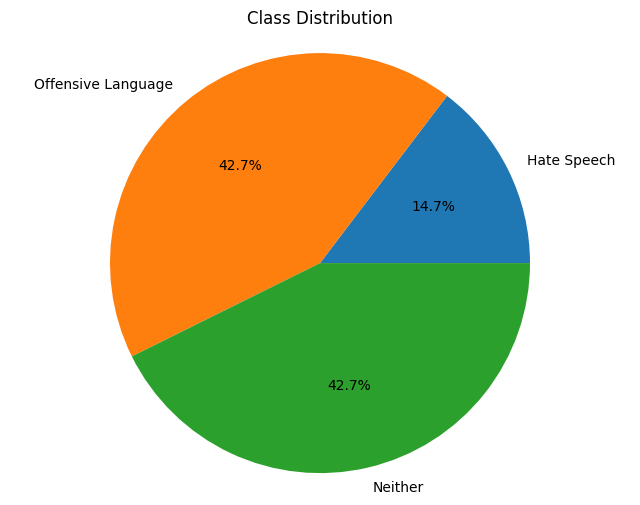

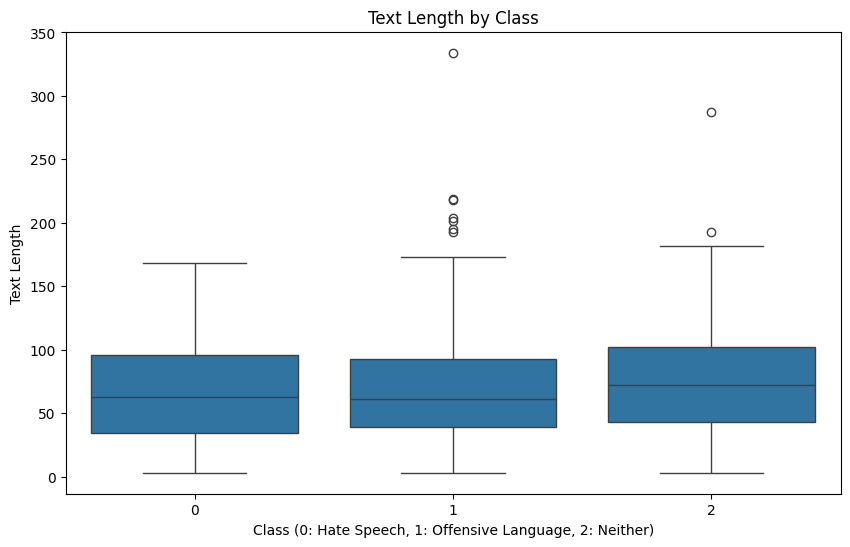

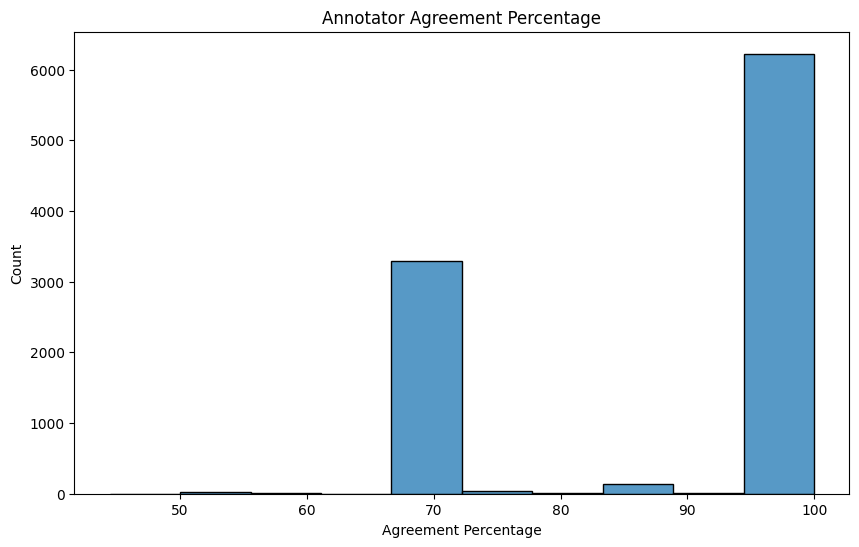

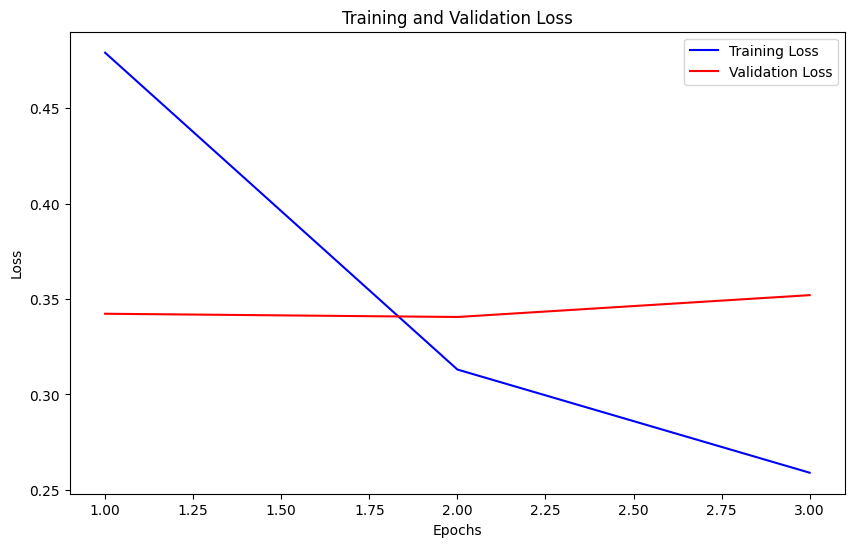

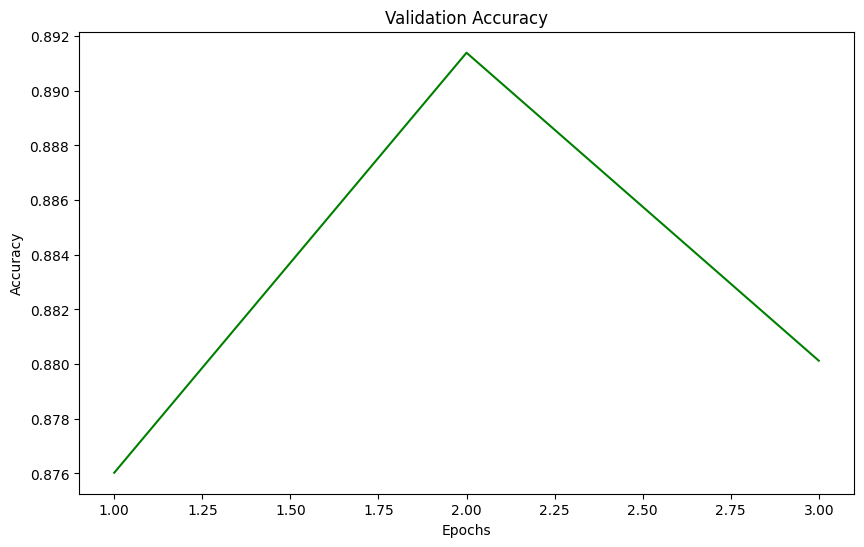

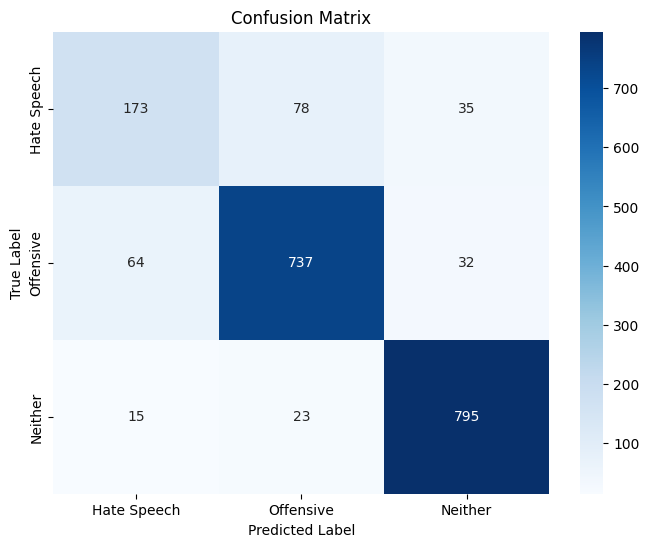

In [26]:
# If this script is run directly
if __name__ == "__main__":
    file_path = "/content/labeled_data.csv"

    # Run the main function
    model, results = main(file_path, epochs=3)

    # Example of prediction on new text
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    sample_text = "i hate black people."
    prediction = predict_hate_speech(sample_text, model, tokenizer, device)
    print(f"Sample text: '{sample_text}'")
    print(f"Prediction: {prediction}")

In [ ]:
# Install dependencies (run this once)
!pip install -q transformers torch

In [27]:
import torch
import re
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# 1. Text cleaning
def clean_text(text: str) -> str:
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)        # remove URLs
    text = re.sub(r'\@\w+|\#', '', text)                       # remove @mentions & #
    text = re.sub(r'^RT[\s]+', '', text)                       # remove RT
    text = re.sub(r'<.*?>', '', text)                          # strip HTML tags
    text = re.sub(r'[^\w\s]', '', text)                        # strip punctuation
    return re.sub(r'\s+', ' ', text).lower().strip()           # normalize spaces & lowercase

# 2. Load model & tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=3
)
model.load_state_dict(torch.load('/content/hate_speech_distilbert_model.pt', map_location=device))
model.to(device)
model.eval()

# 3. Prediction function
def predict(text: str):
    clean = clean_text(text)
    enc = tokenizer(clean,
                    max_length=128,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt')
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    probs = torch.softmax(logits, dim=1)[0]
    idx = probs.argmax().item()
    labels = ['Hate Speech', 'Offensive Language', 'Neither']
    return {
        'input': text,
        'clean': clean,
        'prediction': labels[idx],
        'confidence': float(probs[idx]),
        'all_probs': {labels[i]: float(probs[i]) for i in range(len(labels))}
    }


Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# 4. Example usage
examples = [
    # 3 hate speech examples
    "Go back to your country, chinks this isn’t your home.",
    "All Muslims are terrorists and should go back to where they came from.",
    "Black people are lazy criminals who don’t deserve equal rights.",

    # 3 offensive-language examples
    "Get the hell out of my sight, you worthless piece of shit.",
    "This movie is fucking trash, I wasted two hours of my life.",
    "Get the hell out of my sight, you worthless piece of shit.",

    # 3 neutral (“neither”) examples
    "Anyone have recommendations for good movies on Netflix?",
    "Just brewed my morning coffee ☕️ Feeling ready to tackle the day!",
    "The weather is perfect today: sunny with a light breeze."
]


for ex in examples:
    res = predict(ex)
    print(f"\nText: {res['input']}")
    print(f"Clean: {res['clean']}")
    print(f"→ {res['prediction']} ({res['confidence']:.1%})")
    print("   Probabilities:", res['all_probs'])


Text: Go back to your country, chinks this isn’t your home.
Clean: go back to your country chinks this isnt your home
→ Hate Speech (83.1%)
   Probabilities: {'Hate Speech': 0.8308731913566589, 'Offensive Language': 0.15811137855052948, 'Neither': 0.011015357449650764}

Text: All Muslims are terrorists and should go back to where they came from.
Clean: all muslims are terrorists and should go back to where they came from
→ Hate Speech (68.5%)
   Probabilities: {'Hate Speech': 0.6852535009384155, 'Offensive Language': 0.06890096515417099, 'Neither': 0.24584554135799408}

Text: Black people are lazy criminals who don’t deserve equal rights.
Clean: black people are lazy criminals who dont deserve equal rights
→ Hate Speech (89.5%)
   Probabilities: {'Hate Speech': 0.8950953483581543, 'Offensive Language': 0.05753070116043091, 'Neither': 0.04737399145960808}

Text: Get the hell out of my sight, you worthless piece of shit.
Clean: get the hell out of my sight you worthless piece of shit
→ 